##Packages

In [1]:
!pip install tsmoothie 
# a python library for time-series smoothing and outlier detection in a vectorized way

##Libraries

In [2]:
import pandas as pd #for managing the dataframe

import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.
from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout #the two main technlogies of the model layers
from tensorflow.keras import optimizers #for the training of the model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score #for evaluating model performances
from sklearn.model_selection import train_test_split

from google.colab import drive #to import data from Google Drive

import matplotlib.pyplot as plt #to plot losses of models

from sklearn.linear_model import LinearRegression #for the slope and the value of Y at X=0 of the linear trend line


random_state = 2021

#https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f


##Functions

In [3]:
'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data, timesteps=10): #timesteps means how many days we consider for each block

    X=[]              
    y_MPN10P = [] 
    y_HPN10P = []
    y_LPN10P = []
    y_HPN1P = []
    y_LPN1P = []

    for i in range(len(data)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and labels are saved


        X.append(data[i:(i+timesteps),:5])
        y_MPN10P.append(data[i+timesteps-1,5])
        y_HPN10P.append(data[i+timesteps-1,6])
        y_LPN10P.append(data[i+timesteps-1,7])
        y_HPN1P.append(data[i+timesteps-1,8])
        y_LPN1P.append(data[i+timesteps-1,9])
    
    return np.array(X), [np.array(y_MPN10P), np.array(y_HPN10P), np.array(y_LPN10P), np.array(y_HPN1P), np.array(y_LPN1P)]


##Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#change of course the path if you're using this code as base for something else
dataset_path = "/content/drive/MyDrive/iLab Unit /Ago/proceedit 20220217 iLab - dySPP- S&P500 Knowledge base - OHLCV_MPN10P_data.csv"
ohlcv_mpn10p_data=pd.read_csv(dataset_path)
ohlcv_mpn10p_data.head() #let's have a look to the dataset

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,1,NaN,03-01-2000,"1,469.25","1,478.00","1,438.36","1,455.22","1,455.22","93,18,00,000","1,441.47","1,473.00","1,377.68","1,455.22","1,397.43"
1,2,NaN,04-01-2000,"1,455.22","1,455.22","1,397.43","1,399.42","1,399","1,00,90,00,000","1,441.78","1,473.00","1,377.68","1,413.27","1,377.68"
2,3,NaN,05-01-2000,"1,399.42","1,413.27","1,377.68","1,402.11","1,402","1,08,55,00,000","1,448.00","1,473.00","1,392.10","1,411.90","1,392.10"
3,4,NaN,06-01-2000,"1,402.11","1,411.90","1,392.10","1,403.45","1,403","1,09,23,00,000","1,449.18","1,473.00","1,400.73","1,441.47","1,400.73"
4,5,NaN,07-01-2000,"1,403.45","1,441.47","1,400.73","1,441.47","1,441","1,22,52,00,000","1,449.68","1,473.00","1,395.42","1,464.36","1,441.47"


In [6]:
ohlcv_mpn10p_data = ohlcv_mpn10p_data.replace(',','', regex=True) #remove the ',' otherwise it's impossible to deal with numbers in the dataset
ohlcv_mpn10p_data.tail() #ohoh there's a problem with the last row

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
5562,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5563,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5564,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68
5565,5566,NaN,16-02-2022,4455.75,4489.55,4429.68,4475.01,4475,3478750000,4416.55,4456.06,4373.81,4456.06,4373.81
5566,5567,NaN,17-02-2022,4456.06,4456.06,4373.81,4380.26,4380,3596510000,#NUM!,#NUM!,#NUM!,NaN,NaN


In [7]:
ohlcv_mpn10p_data = ohlcv_mpn10p_data[:-1] #simply remove the last row

In [8]:
ohlcv_mpn10p_data.tail() #now it's perfect!

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
5561,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41
5562,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5563,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5564,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68
5565,5566,NaN,16-02-2022,4455.75,4489.55,4429.68,4475.01,4475,3478750000,4416.55,4456.06,4373.81,4456.06,4373.81


In [9]:
#building the dataframe with just the necessary columns (removing 'id', 'uuid' and 'ACPCP_adjusted_close_price_current_period' column) 
df = ohlcv_mpn10p_data[['OPCP_open_price_current_period','HPCP_high_price_current_period','LPCP_low_price_current_period',
                        'CPCP_close_price_current_period','VTCP_volume_of_transactions_current_period','MPN10P_median_price_next_10_periods',
                        'HPN10P_highest_price_next_10_periods', 'LPN10P_lowest_price_next_10_periods', 'HPN1P_high_price_next_1_period', 
                        'LPN1P_low_price_next_1_period' ]]

#renaming columns to have a more compact and a better reading of the df
df = df.rename(columns={"OPCP_open_price_current_period":"OPCP", "HPCP_high_price_current_period":"HPCP", 
                        "LPCP_low_price_current_period":"LPCP", "CPCP_close_price_current_period":"CPCP", 
                        "VTCP_volume_of_transactions_current_period":"VTCP", "MPN10P_median_price_next_10_periods":"MPN10P",
                        "HPN10P_highest_price_next_10_periods":"HPN10P", 'LPN10P_lowest_price_next_10_periods':'LPN10P',
                        'HPN1P_high_price_next_1_period':'HPN1P','LPN1P_low_price_next_1_period':'LPN1P'
                      })

df.head()

,OPCP,HPCP,LPCP,CPCP,VTCP,MPN10P,HPN10P,LPN10P,HPN1P,LPN1P
0,1469.25,1478.00,1438.36,1455.22,931800000,1441.47,1473.00,1377.68,1455.22,1397.43
1,1455.22,1455.22,1397.43,1399.42,1009000000,1441.78,1473.00,1377.68,1413.27,1377.68
2,1399.42,1413.27,1377.68,1402.11,1085500000,1448.00,1473.00,1392.10,1411.90,1392.10
3,1402.11,1411.90,1392.10,1403.45,1092300000,1449.18,1473.00,1400.73,1441.47,1400.73
4,1403.45,1441.47,1400.73,1441.47,1225200000,1449.68,1473.00,1395.42,1464.36,1441.47


In [10]:
print("Number of NaN values:")
print(df.isna().sum()) #let's check also whether there are missing values or not

Number of NaN values:
OPCP      0
HPCP      0
LPCP      0
CPCP      0
VTCP      0
MPN10P    0
HPN10P    0
LPN10P    0
HPN1P     0
LPN1P     0
dtype: int64


##Preprocessing

In [11]:
df_array=np.zeros((df.shape), dtype=np.float64) #necessary to deal with filter results
print(df_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
'''Kalman filter (rounding data)'''
kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1}) #values for Kalman filters parameters 
                                                                                                                #are taken from an example in the original code 
                                                                                                                #of the library

for i in range(len(df.columns)): #this is the more convenient way I've found to apply the filter
  kalman_smoother.smooth(df[df.columns[i]].astype(float))
  df_array[:,i] = kalman_smoother.smooth_data

In [13]:
print(pd.DataFrame(df_array)) #I use pd.DataFrame(array) to print because in this way it's neater

                0            1  ...            8            9
0     1419.971823  1426.152384  ...  1401.129925  1354.152395
1     1420.629306  1429.384782  ...  1412.964485  1373.499923
2     1417.075273  1429.524661  ...  1424.619537  1391.413630
3     1417.241319  1432.844682  ...  1437.232627  1407.572043
4     1421.816521  1440.252055  ...  1447.671148  1422.125801
...           ...          ...  ...          ...          ...
5561  4509.336373  4541.536570  ...  4519.471890  4438.967861
5562  4489.976141  4519.474691  ...  4494.755071  4420.423764
5563  4465.732400  4494.689452  ...  4480.400924  4411.302965
5564  4448.824460  4480.205070  ...  4468.972111  4400.799940
5565  4435.859969  4468.562904  ...  4455.537735  4386.172644

[5566 rows x 10 columns]


In [14]:
'''E_logarithmic filter (detrending)'''
df_array=np.log(df_array)

In [15]:
print(pd.DataFrame(df_array))

             0         1         2  ...         7         8         9
0     7.258392  7.262735  7.230586  ...  7.208256  7.245034  7.210931
1     7.258855  7.264999  7.234901  ...  7.220803  7.253445  7.225117
2     7.256350  7.265097  7.238616  ...  7.230562  7.261660  7.238076
3     7.256468  7.267417  7.244414  ...  7.236332  7.270475  7.249622
4     7.259691  7.272573  7.251671  ...  7.237730  7.277711  7.259908
...        ...       ...       ...  ...       ...       ...       ...
5561  8.413905  8.421021  8.403417  ...  8.381761  8.416150  8.398177
5562  8.409603  8.416151  8.398162  ...  8.382090  8.410666  8.393991
5563  8.404189  8.410652  8.394342  ...  8.382610  8.407468  8.391925
5564  8.400395  8.407424  8.392976  ...  8.383066  8.404914  8.389542
5565  8.397477  8.404822  8.391740  ...  8.383480  8.401903  8.386212

[5566 rows x 10 columns]


In [16]:
'''Robust scaler (scaling)'''
robust_scaler = RobustScaler()

for i in range(len(df.columns)): #in such a way I can have only a RS for each column
  col_scaled = robust_scaler.fit_transform(df_array[:,i].reshape(-1,1)) 
  df_array[:,i] = col_scaled[:, 0]

In [17]:
print(pd.DataFrame(df_array))

             0         1         2  ...         7         8         9
0     0.009470  0.008312 -0.025515  ... -0.028584 -0.021211 -0.058405
1     0.010244  0.012111 -0.018346  ... -0.008275 -0.007102 -0.034834
2     0.006058  0.012276 -0.012173  ...  0.007522  0.006677 -0.013304
3     0.006254  0.016169 -0.002538  ...  0.016864  0.021462  0.005879
4     0.011640  0.024824  0.009521  ...  0.019126  0.033601  0.022970
...        ...       ...       ...  ...       ...       ...       ...
5561  1.940277  1.952386  1.923323  ...  1.871023  1.943177  1.914197
5562  1.933087  1.944213  1.914591  ...  1.871556  1.933978  1.907241
5563  1.924041  1.934983  1.908244  ...  1.872397  1.928613  1.903809
5564  1.917702  1.929565  1.905973  ...  1.873135  1.924329  1.899849
5565  1.912826  1.925198  1.903920  ...  1.873806  1.919279  1.894317

[5566 rows x 10 columns]


##Training and test data

In [18]:
'''splitting training and testing data'''
train_data, test_data = train_test_split(df_array, train_size=0.9, shuffle = False,random_state=2021) #with shuffle=False, data is acquired in sequence

In [19]:
print(train_data.shape[0],"days for training.")
print(test_data.shape[0],"days for testing.")

5009 days for training.
557 days for testing.


In [20]:
X_train, y_train = building_data_sequences(train_data) #see Functions section above
X_test, y_test = building_data_sequences(test_data) 

##Model

In [21]:
input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

Input shape obtained is: (10, 5)


In [22]:
'''Model parameters: in order to understand, consult the original documentation (case_version_cat Tab) '''
n_epochs = 40
batch_size = 16
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0
lr=0.0005 #a couple of test with lower values

In [23]:
# targets = ['MPN10P']
# models = {} #to store everything regarding models: name, model itself, lossess, train and test predictions, evaluations and so on

In [24]:
targets = ['MPN10P', 'HPN10P', 'LPN10P', 'HPN1P', 'LPN1P'] 
models = {} #to store everything regarding models: name, model itself, lossess, train and test predictions, evaluations and so on

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

Training model for  MPN10P
Epoch 1/40
250/250 [==============================] - 139s 537ms/step - loss: 0.0106 - val_loss: 0.0028
Epoch 2/40
250/250 [==============================] - 133s 534ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 3/40
250/250 [==============================] - 132s 527ms/step - loss: 0.0343 - val_loss: 0.1061
Epoch 4/40
250/250 [==============================] - 131s 522ms/step - loss: 0.0913 - val_loss: 0.2210
Epoch 5/40
250/250 [==============================] - 140s 559ms/step - loss: 0.1428 - val_loss: 0.4187
Epoch 6/40
250/250 [==============================] - 142s 569ms/step - loss: 0.1618 - val_loss: 0.5863
Epoch 7/40
250/250 [==============================] - 155s 622ms/step - loss: 0.1068 - val_loss: 0.1883


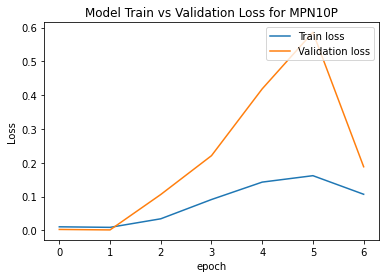


Training model for  HPN10P
Epoch 1/40
250/250 [==============================] - 112s 430ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 2/40
250/250 [==============================] - 106s 423ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/40
250/250 [==============================] - 102s 407ms/step - loss: 0.0196 - val_loss: 0.1926
Epoch 4/40
250/250 [==============================] - 103s 410ms/step - loss: 0.0107 - val_loss: 0.0155
Epoch 5/40
250/250 [==============================] - 102s 410ms/step - loss: 0.0064 - val_loss: 0.0370
Epoch 6/40
250/250 [==============================] - 106s 422ms/step - loss: 0.0104 - val_loss: 0.0831


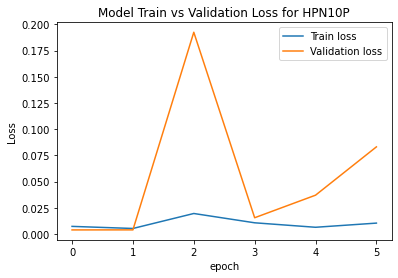


Training model for  LPN10P
Epoch 1/40
250/250 [==============================] - 141s 547ms/step - loss: 0.0162 - val_loss: 0.0179
Epoch 2/40
250/250 [==============================] - 131s 523ms/step - loss: 0.0150 - val_loss: 0.0360
Epoch 3/40
250/250 [==============================] - 132s 530ms/step - loss: 0.0335 - val_loss: 0.1735
Epoch 4/40
250/250 [==============================] - 127s 509ms/step - loss: 0.0180 - val_loss: 0.1747
Epoch 5/40
250/250 [==============================] - 122s 489ms/step - loss: 0.0241 - val_loss: 0.0328
Epoch 6/40
250/250 [==============================] - 127s 508ms/step - loss: 0.0221 - val_loss: 0.0195


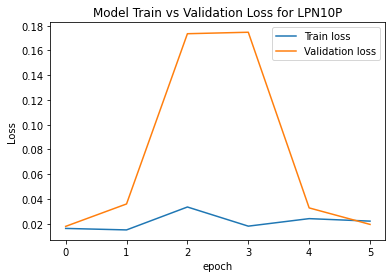


Training model for  HPN1P
Epoch 1/40
250/250 [==============================] - 141s 548ms/step - loss: 0.0071 - val_loss: 0.0013
Epoch 2/40
250/250 [==============================] - 134s 536ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 3/40
250/250 [==============================] - 134s 536ms/step - loss: 0.0312 - val_loss: 0.2856
Epoch 4/40
250/250 [==============================] - 138s 554ms/step - loss: 0.0484 - val_loss: 0.1713
Epoch 5/40
250/250 [==============================] - 133s 532ms/step - loss: 0.0215 - val_loss: 0.2235
Epoch 6/40
250/250 [==============================] - 137s 550ms/step - loss: 0.0280 - val_loss: 0.2218


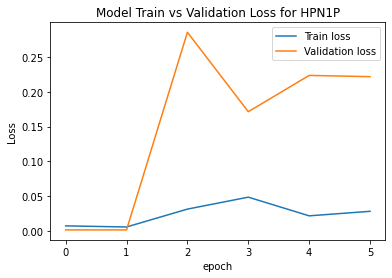


Training model for  LPN1P
Epoch 1/40
250/250 [==============================] - 103s 393ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 2/40
250/250 [==============================] - 100s 399ms/step - loss: 0.0090 - val_loss: 0.0039
Epoch 3/40
250/250 [==============================] - 96s 383ms/step - loss: 0.0271 - val_loss: 0.1138
Epoch 4/40
250/250 [==============================] - 95s 382ms/step - loss: 0.0106 - val_loss: 0.1059
Epoch 5/40
250/250 [==============================] - 96s 384ms/step - loss: 0.0117 - val_loss: 0.1026
Epoch 6/40
250/250 [==============================] - 97s 389ms/step - loss: 0.0114 - val_loss: 0.1134


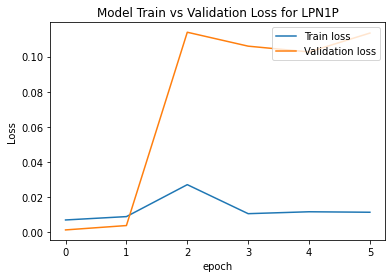

In [25]:
from tensorflow import keras
from matplotlib import pyplot

for i in range(len(targets)):

  print("Training model for ", targets[i])
  model = tf.keras.Sequential()

  '''These are the 5 layers that characterize each model (see case_version_cat Tab)'''

  model.add(LSTM(2**twoexp_nodes_number_layer_1,input_shape=input_shape,return_sequences=True))
  model.add(LSTM(2**twoexp_nodes_number_layer_2, return_sequences=True))
  model.add(LSTM(2**twoexp_nodes_number_layer_3))
  model.add(Dense(2**twoexp_nodes_number_layer_4))
  model.add(Dense(2**twoexp_nodes_number_layer_5))

  #compiling model
  model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')

  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
  #patience -  the number of epochs to wait before early stop if no progress on the validation set. The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.

  #fitting model
  hist = model.fit(X_train, y_train[i], batch_size=batch_size, epochs=n_epochs,validation_split = 0.2,shuffle = False, callbacks = [early_stop])
  #Shuffle - whether to shuffle the training data before each epoch
  #we can acheive the reproducible results with the help of random_state =2021


  #enriching models vocabulary 
  # models[targets[i]] = {'model': model, 'train':{'val_loss': hist.history['val_loss']}, 'test':{}} 
  # plot training history

  # print(models[targets[i]])
  pyplot.plot(hist.history['loss'], label='train_loss')
  pyplot.plot(hist.history['val_loss'], label='val_loss')
  plt.title('Model Train vs Validation Loss for ' + targets[i])
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  pyplot.legend(['Train loss', 'Validation loss'], loc='upper right')
  pyplot.show() 
  print()

##Evaluation

In [26]:
'''Enriching the models vocabulary with predictions about training set'''
for key in models:

  idx = list(models.keys()).index(key)
  train_predictions = models[key]['model'].predict(X_train) #predict predictions
  train_predictions = np.exp(robust_scaler.inverse_transform(train_predictions)) #convert prediction
  models[key]['train']['predictions'] = train_predictions #attach prediction
  y_transformed = np.exp(robust_scaler.inverse_transform(y_train[idx].reshape(-1,1))) #the same here for the labels (in order to compare them with the predictions)
  mse = mean_squared_error(y_transformed, train_predictions) #mse
  r2 = r2_score(y_transformed, train_predictions) #r2 score
  models[key]['train']['evaluation'] = {'mse': mse, 'r2' : r2 } #save them in the vocabulary

In [27]:
'''Enriching the models vocabulary with predictions about test set'''
for key in models:
 
  idx = list(models.keys()).index(key)
  test_predictions = models[key]['model'].predict(X_test) 
  test_predictions = np.exp(robust_scaler.inverse_transform(test_predictions)) 
  models[key]['test']['predictions'] = test_predictions 
  y_transformed = np.exp(robust_scaler.inverse_transform(y_test[idx].reshape(-1,1))) 
  mse = mean_squared_error(y_transformed, test_predictions) 
  r2 = r2_score(y_transformed, test_predictions) 
  models[key]['test']['evaluation'] = {'mse': mse, 'r2' : r2 } 

In [34]:
'''Notice that, in general, while on the training set the model is good (even if the mse is still high),
on the test set the model is very bad with a terrible mse and a r2 score which is strangely perfect (nonetheless in some cases it oscillates, but still it's good)'''

for key in models: #for each model, simply print the mse and the r2 score for training and testing
  print('MSE and R2_score for Model_'+key)
  print('       Training:', models[key]['train']['evaluation'])
  print('       Testing:',models[key]['test']['evaluation'])
  print()

##Plot

In [29]:
# '''These are the plots of the losses for each model. Notice that the trend is correct (it slowly increase and then become constant). However, sometimes, 
# they present these drops, so my suggestion for future improvement is to try to make the models more stable.  '''

# fig, axs = plt.subplots(1, 5, figsize=(30,5))

# for key in models:

#   idx = list(models.keys()).index(key)
#   axs[idx].plot(np.linspace(0,n_epochs,n_epochs), -np.array(models[key]['train']['loss']), scaley=True)
#   axs[idx].set_title('Model_'+key)

# for ax in axs.flat:
#     ax.set(xlabel='epoch', ylabel='loss')

# for ax in axs.flat:
#     ax.label_outer()

##Output file

In [30]:
'''Creating the df with all the predictions of the models'''

targets_columns = []

for key in models:

  train_array = np.concatenate(models[key]['train']['predictions']).ravel()
  test_array = np.concatenate(models[key]['test']['predictions']).ravel()
  target_col = np.concatenate((train_array, test_array))
  targets_columns.append(target_col)


targets_df = pd.DataFrame(targets_columns).T
targets_df = targets_df.rename(columns={0:'MPN10P_prediction',1:'HPN10P_prediction',2:'LPN10P_prediction',3:'HPN1P_prediction',4:'LPN1P_prediction'})
targets_df

""


In [31]:
'''Creating the df on which attach the predicted results'''
output_df = ohlcv_mpn10p_data.iloc[9:,:].reset_index().drop(['index'], axis=1) #take data after timesteps-1 days
output_df

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,10,NaN,14-01-2000,1449.68,1473.00,1449.68,1465.15,1465,1085900000,1413.49,1465.71,1350.14,1465.15,1451.30
1,11,NaN,18-01-2000,1465.15,1465.15,1451.30,1455.14,1455,1056700000,1408.02,1465.71,1350.14,1461.39,1448.68
2,12,NaN,19-01-2000,1455.14,1461.39,1448.68,1455.90,1456,1087800000,1405.42,1465.71,1350.14,1465.71,1438.54
3,13,NaN,20-01-2000,1455.90,1465.71,1438.54,1445.57,1446,1100700000,1404.09,1454.09,1350.14,1453.18,1439.60
4,14,NaN,21-01-2000,1445.57,1453.18,1439.60,1441.36,1441,1209800000,1404.09,1454.09,1350.14,1454.09,1395.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41
5553,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5554,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5555,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68


In [32]:
output_df=pd.concat([output_df,targets_df], axis=1)
output_df

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,10,NaN,14-01-2000,1449.68,1473.00,1449.68,1465.15,1465,1085900000,1413.49,1465.71,1350.14,1465.15,1451.30
1,11,NaN,18-01-2000,1465.15,1465.15,1451.30,1455.14,1455,1056700000,1408.02,1465.71,1350.14,1461.39,1448.68
2,12,NaN,19-01-2000,1455.14,1461.39,1448.68,1455.90,1456,1087800000,1405.42,1465.71,1350.14,1465.71,1438.54
3,13,NaN,20-01-2000,1455.90,1465.71,1438.54,1445.57,1446,1100700000,1404.09,1454.09,1350.14,1453.18,1439.60
4,14,NaN,21-01-2000,1445.57,1453.18,1439.60,1441.36,1441,1209800000,1404.09,1454.09,1350.14,1454.09,1395.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41
5553,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5554,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5555,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68


In [33]:
'''Save the output file on drive'''
#change of course the path if you're using this code as base for something else
output_path='/content/drive/MyDrive/iLab Unit /Ago/'
output_df.to_csv(output_path+'output_file.csv')